In [1]:
!pip install yfinance ta textblob plotly tensorflow pandas numpy scikit-learn


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from textblob import TextBlob
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta
import requests
import matplotlib.pyplot as plt


In [11]:
def get_stock_data(ticker, start='2015-01-01', end=None):
    if end is None:
        end = datetime.today().strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start, end=end, auto_adjust=False)
    # Rename columns to standard names
    df.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    df.dropna(inplace=True)
    return df

ticker = input("Enter stock ticker (e.g., AAPL, MSFT): ").upper()
df = get_stock_data(ticker)
display(df.tail())

Enter stock ticker (e.g., AAPL, MSFT): MSFT


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-11-03,517.030029,517.030029,524.960022,514.590027,519.809998,22374700
2025-11-04,514.330017,514.330017,515.549988,507.839996,511.760010,20958700
2025-11-05,507.160004,507.160004,514.830017,506.579987,513.299988,23024300
2025-11-06,497.100006,497.100006,505.700012,495.809998,505.660004,27406500
2025-11-07,496.820007,496.820007,499.380005,493.250000,496.950012,23980600


In [12]:
def add_technical_indicators(df):
    # Select only the 'Close' column for technical indicators
    close_prices = df['Close']

    df['MA20'] = close_prices.rolling(window=20).mean()
    df['MA50'] = close_prices.rolling(window=50).mean()
    df['MA200'] = close_prices.rolling(window=200).mean()
    df['RSI'] = ta.momentum.RSIIndicator(close_prices, window=14).rsi()
    bb = ta.volatility.BollingerBands(close_prices, window=20, window_dev=2)
    df['BB_High'] = bb.bollinger_hband()
    df['BB_Low'] = bb.bollinger_lband()
    macd = ta.trend.MACD(close_prices)
    df['MACD'] = macd.macd()
    df['Signal'] = macd.macd_signal()
    return df

df = add_technical_indicators(df)
df.dropna(inplace=True)
display(df.tail())

,Open,High,Low,Close,Adj Close,Volume,MA20,MA50,MA200,RSI,BB_High,BB_Low,MACD,Signal
Date,,,,,,,,,,,,,,
2025-11-03,517.030029,517.030029,524.960022,514.590027,519.809998,22374700,517.825003,510.137802,457.478651,48.092123,535.979824,499.670182,3.464185,3.726364
2025-11-04,514.330017,514.330017,515.549988,507.839996,511.760010,20958700,517.145003,510.212202,457.877001,43.195061,535.721180,498.568826,2.194602,3.420011
2025-11-05,507.160004,507.160004,514.830017,506.579987,513.299988,23024300,516.319501,510.373601,458.281900,42.328601,535.229915,497.409086,1.074391,2.950887
2025-11-06,497.100006,497.100006,505.700012,495.809998,505.660004,27406500,515.239999,510.291801,458.580950,35.731007,536.140644,494.339355,-0.674656,2.225779
2025-11-07,496.820007,496.820007,499.380005,493.250000,496.950012,23980600,514.420999,510.046801,458.839700,34.360079,537.324525,491.517473,-2.241519,1.332319


In [16]:
def prepare_data(df):
    features = ['Close','MA20','MA50','MA200','RSI','MACD','Signal','Sentiment']
    df = df[features]
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    X, y = [], []
    lookback = 60
    for i in range(lookback, len(scaled)):
        X.append(scaled[i-lookback:i])
        y.append(scaled[i, 0])
    X, y = np.array(X), np.array(y)
    return X, y, scaler

X, y, scaler = prepare_data(df)
X.shape, y.shape

((2471, 60, 8), (2471,))

In [14]:
def get_news_sentiment(ticker):
    # This is a placeholder function. A real implementation would involve
    # using a news API (like NewsAPI, Alpha Vantage, etc.) to fetch news headlines
    # related to the stock ticker and then performing sentiment analysis on them.
    # For demonstration purposes, we'll return a placeholder sentiment score.

    # In a real scenario, you would fetch news like this:
    # url = f'https://newsapi.org/v2/everything?q={ticker}&apiKey=YOUR_NEWS_API_KEY'
    # response = requests.get(url)
    # articles = response.json()['articles']
    # headlines = [article['title'] for article in articles]
    # sentiment_scores = [TextBlob(headline).sentiment.polarity for headline in headlines]
    # return pd.Series(sentiment_scores).mean() if sentiment_scores else 0

    # Placeholder implementation: Generate random sentiment for demonstration
    return np.random.uniform(-1, 1)

# Add a 'Sentiment' column to the dataframe.
# In a real application, you would calculate sentiment for each day based on news.
# For this example, we'll add a placeholder sentiment column with random values.
df['Sentiment'] = [get_news_sentiment(ticker) for _ in range(len(df))]

display(df.tail())

,Open,High,Low,Close,Adj Close,Volume,MA20,MA50,MA200,RSI,BB_High,BB_Low,MACD,Signal,Sentiment
Date,,,,,,,,,,,,,,,
2025-11-03,517.030029,517.030029,524.960022,514.590027,519.809998,22374700,517.825003,510.137802,457.478651,48.092123,535.979824,499.670182,3.464185,3.726364,0.653300
2025-11-04,514.330017,514.330017,515.549988,507.839996,511.760010,20958700,517.145003,510.212202,457.877001,43.195061,535.721180,498.568826,2.194602,3.420011,0.253351
2025-11-05,507.160004,507.160004,514.830017,506.579987,513.299988,23024300,516.319501,510.373601,458.281900,42.328601,535.229915,497.409086,1.074391,2.950887,0.227618
2025-11-06,497.100006,497.100006,505.700012,495.809998,505.660004,27406500,515.239999,510.291801,458.580950,35.731007,536.140644,494.339355,-0.674656,2.225779,0.448870
2025-11-07,496.820007,496.820007,499.380005,493.250000,496.950012,23980600,514.420999,510.046801,458.839700,34.360079,537.324525,491.517473,-2.241519,1.332319,-0.782763


In [21]:
import requests
from textblob import TextBlob
from datetime import datetime, timedelta


ALPHA_VANTAGE_API_KEY = "F4KM1CZRQHUVON42"

def get_news_sentiment(ticker, days_back=7):
    """
    Fetches recent news sentiment for the given stock ticker using Alpha Vantage News API.
    Returns the average sentiment score for each day.
    """
    print(f"Fetching news for {ticker} from Alpha Vantage...")

    url = f"https://www.alphavantage.co/query"
    params = {
        "function": "NEWS_SENTIMENT",
        "tickers": ticker,
        "apikey": ALPHA_VANTAGE_API_KEY,
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()

        if "feed" not in data:
            print("⚠️ No news data found or API limit reached.")
            return 0.0

        # Collect all headlines and summaries
        sentiments = []
        cutoff_date = datetime.now() - timedelta(days=days_back)
        for item in data["feed"]:
            if "title" in item and "time_published" in item:
                published = datetime.strptime(item["time_published"], "%Y%m%dT%H%M%S")
                if published >= cutoff_date:
                    headline = item["title"]
                    summary = item.get("summary", "")
                    text = headline + " " + summary
                    sentiment = TextBlob(text).sentiment.polarity
                    sentiments.append(sentiment)

        # Average sentiment for the period
        avg_sentiment = np.mean(sentiments) if sentiments else 0.0
        print(f"Average sentiment (last {days_back} days): {avg_sentiment:.3f}")
        return avg_sentiment

    except Exception as e:
        print(f"Error fetching news sentiment: {e}")
        return 0.0


# Add sentiment column to dataframe
# We'll compute one sentiment score for the recent period and fill it in for all rows
sentiment_score = get_news_sentiment(ticker)
df["Sentiment"] = sentiment_score

display(df.tail())


Fetching news for MSFT from Alpha Vantage...
Average sentiment (last 7 days): 0.149


/tmp/ipython-input-1214190662.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close,Adj Close,Volume,MA20,MA50,MA200,RSI,BB_High,BB_Low,MACD,Signal,Sentiment,Predicted
Date,,,,,,,,,,,,,,,,
2025-11-03,517.030029,517.030029,524.960022,514.590027,519.809998,22374700,517.825003,510.137802,457.478651,48.092123,535.979824,499.670182,3.464185,3.726364,0.149297,521.353468
2025-11-04,514.330017,514.330017,515.549988,507.839996,511.760010,20958700,517.145003,510.212202,457.877001,43.195061,535.721180,498.568826,2.194602,3.420011,0.149297,515.467963
2025-11-05,507.160004,507.160004,514.830017,506.579987,513.299988,23024300,516.319501,510.373601,458.281900,42.328601,535.229915,497.409086,1.074391,2.950887,0.149297,509.412194
2025-11-06,497.100006,497.100006,505.700012,495.809998,505.660004,27406500,515.239999,510.291801,458.580950,35.731007,536.140644,494.339355,-0.674656,2.225779,0.149297,504.135209
2025-11-07,496.820007,496.820007,499.380005,493.250000,496.950012,23980600,514.420999,510.046801,458.839700,34.360079,537.324525,491.517473,-2.241519,1.332319,0.149297,497.639417


In [22]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.0180 - val_loss: 8.5819e-04
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0012 - val_loss: 7.5294e-04
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.0010 - val_loss: 7.8227e-04
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0011 - val_loss: 6.7966e-04
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 8.0371e-04 - val_loss: 0.0040
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 9.6449e-04 - val_loss: 4.0697e-04
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - loss: 8.4623e-04 - val_loss: 0.0020
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 9.6868e-04 - val_loss: 4.8655e-04
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 7.6421e-04 - val_loss: 5.5664e-04
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 9.2810e-04 - val_loss: 3.9431e-04
Epoch 

78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step


/tmp/ipython-input-3202023484.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Predicted'] = predicted_prices


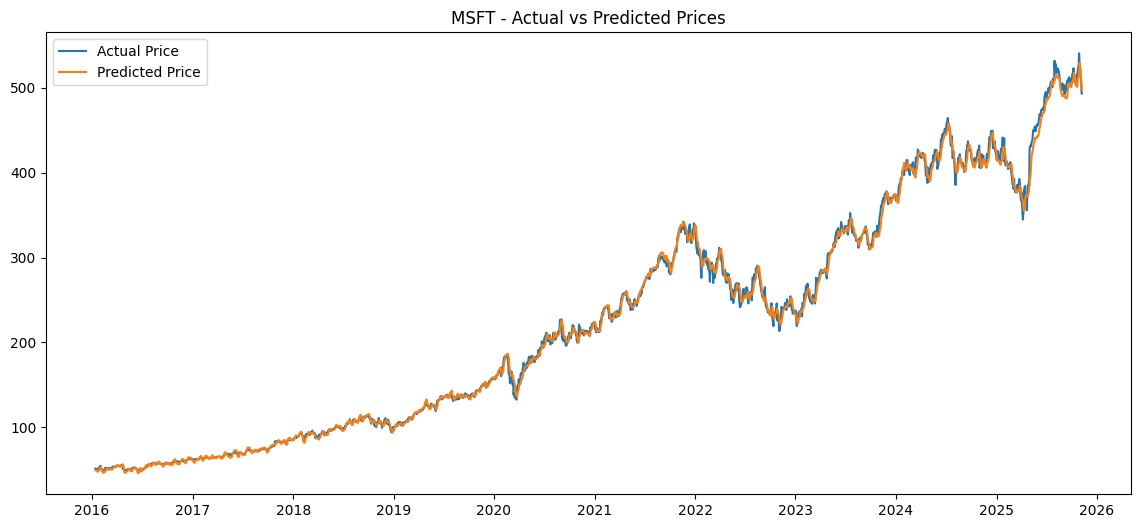

In [18]:
predicted = model.predict(X)
predicted_prices = scaler.inverse_transform(np.concatenate((predicted, np.zeros((predicted.shape[0], X.shape[2]-1))), axis=1))[:,0]

df = df.iloc[60:]
df['Predicted'] = predicted_prices

plt.figure(figsize=(14,6))
plt.plot(df.index, df['Close'], label='Actual Price')
plt.plot(df.index, df['Predicted'], label='Predicted Price')
plt.title(f'{ticker} - Actual vs Predicted Prices')
plt.legend()
plt.show()


In [19]:
def analyze_trends(df):
    last_close = df['Close'].iloc[-1]
    ma20, ma50 = df['MA20'].iloc[-1], df['MA50'].iloc[-1]
    rsi = df['RSI'].iloc[-1]
    sentiment = df['Sentiment'].iloc[-1]

    print("\n--- STOCK ANALYSIS REPORT ---")
    print(f"Latest Price: {last_close:.2f}")
    print(f"RSI: {rsi:.2f} → {'Overbought' if rsi>70 else 'Oversold' if rsi<30 else 'Neutral'}")
    print(f"Sentiment Score: {sentiment:.2f} → {'Positive' if sentiment>0 else 'Negative' if sentiment<0 else 'Neutral'}")

    if ma20 > ma50:
        print("Trend: Bullish (Short-term moving average above long-term)")
    else:
        print("Trend: Bearish (Short-term moving average below long-term)")

    print("-----------------------------")

analyze_trends(df)



--- STOCK ANALYSIS REPORT ---
Latest Price: 493.25
RSI: 34.36 → Neutral
Sentiment Score: -0.78 → Negative
Trend: Bullish (Short-term moving average above long-term)
-----------------------------


In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=df['Predicted'], name='Predicted', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df.index, y=df['MA20'], name='MA20', line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=df.index, y=df['MA50'], name='MA50', line=dict(dash='dot')))
fig.update_layout(title=f"{ticker} Price Forecast & Trend", xaxis_title="Date", yaxis_title="Price")
fig.show()



Forecasting next 7 days for MSFT...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



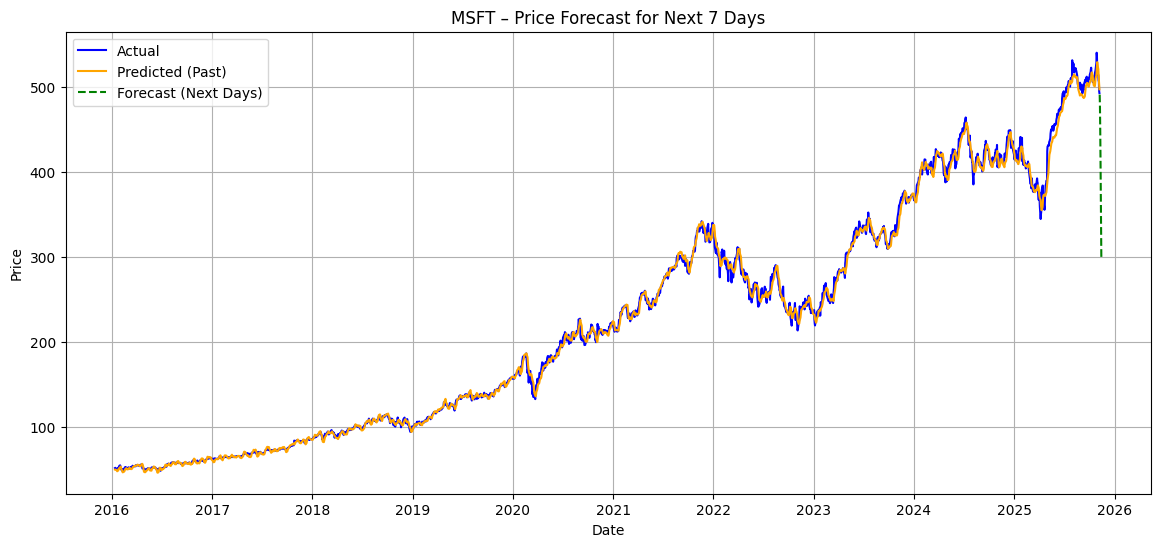

In [23]:
# ---------------------------------------
# 🔮 FUTURE FORECASTING (Next N Days)
# ---------------------------------------

def forecast_future_prices(model, df, scaler, days_ahead=5, lookback=60):
    """
    Forecast next N days using the trained LSTM model.
    Uses the last `lookback` days from df as input for prediction.
    """
    print(f"\nForecasting next {days_ahead} days for {ticker}...")

    features = ['Close','MA20','MA50','MA200','RSI','MACD','Signal','Sentiment']
    last_data = df[features].values[-lookback:]
    scaled_last = scaler.transform(last_data)

    forecast = []
    current_batch = scaled_last.reshape((1, lookback, len(features)))

    for _ in range(days_ahead):
        pred = model.predict(current_batch, verbose=0)
        forecast.append(pred[0, 0])
        # shift window
        new_row = np.zeros((1, len(features)))
        new_row[0, 0] = pred[0, 0]  # predicted close
        current_batch = np.append(current_batch[:, 1:, :], [[new_row[0]]], axis=1)

    # Inverse transform predicted close values
    temp = np.zeros((len(forecast), len(features)))
    temp[:, 0] = forecast
    forecast_prices = scaler.inverse_transform(temp)[:, 0]

    future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=days_ahead)
    forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': forecast_prices})
    forecast_df.set_index('Date', inplace=True)
    return forecast_df


# Predict next N days
future_days = 7  # user can change this
future_df = forecast_future_prices(model, df, scaler, days_ahead=future_days)

# Combine with historical data
combined_df = pd.concat([df[['Close', 'Predicted']], future_df], axis=0)

# ---------------------------------------
# 📊 VISUALIZATION – EXTENDED CHART
# ---------------------------------------

plt.figure(figsize=(14,6))
plt.plot(df.index, df['Close'], label='Actual', color='blue')
plt.plot(df.index, df['Predicted'], label='Predicted (Past)', color='orange')
plt.plot(future_df.index, future_df['Forecast'], label='Forecast (Next Days)', color='green', linestyle='--')
plt.title(f'{ticker} – Price Forecast for Next {future_days} Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
def future_analysis(future_df, sentiment):
    start_price = future_df['Forecast'].iloc[0]
    end_price = future_df['Forecast'].iloc[-1]
    change = ((end_price - start_price) / start_price) * 100

    print("\n--- 📊 FUTURE TREND ANALYSIS ---")
    if change > 2:
        print(f"Forecast: 📈 Strong bullish trend expected (+{change:.2f}%)")
    elif change > 0:
        print(f"Forecast: Slight upward trend (+{change:.2f}%)")
    elif change < -2:
        print(f"Forecast: 📉 Strong bearish trend expected ({change:.2f}%)")
    else:
        print(f"Forecast: Slight downward/neutral movement ({change:.2f}%)")

    if sentiment > 0.1:
        print("Sentiment: Positive 🟢 — supporting bullish outlook")
    elif sentiment < -0.1:
        print("Sentiment: Negative 🔴 — may limit price growth")
    else:
        print("Sentiment: Neutral ⚪ — no clear emotional bias in market")
    print("--------------------------------\n")

future_analysis(future_df, df['Sentiment'].iloc[-1])



--- 📊 FUTURE TREND ANALYSIS ---
Forecast: 📉 Strong bearish trend expected (-39.11%)
Sentiment: Positive 🟢 — supporting bullish outlook
--------------------------------

